In [136]:
library(tidyverse)
library(magrittr)
library(caret)
library(zeallot)
source("R/hte_caret.R")

In [262]:
?gbm

gbm                    package:gbm                     R Documentation

_G_e_n_e_r_a_l_i_z_e_d _B_o_o_s_t_e_d _R_e_g_r_e_s_s_i_o_n _M_o_d_e_l_i_n_g

_D_e_s_c_r_i_p_t_i_o_n:

     Fits generalized boosted regression models.

_U_s_a_g_e:

     gbm(formula = formula(data),
         distribution = "bernoulli",
         data = list(),
         weights,
         var.monotone = NULL,
         n.trees = 100,
         interaction.depth = 1,
         n.minobsinnode = 10,
         shrinkage = 0.001,
         bag.fraction = 0.5,
         train.fraction = 1.0,
         cv.folds=0,
         keep.data = TRUE,
         verbose = "CV",
         class.stratify.cv=NULL,
         n.cores = NULL)
     
     gbm.fit(x, y,
             offset = NULL,
             misc = NULL,
             distribution = "bernoulli",
             w = NULL,
             var.monotone = NULL,
             n.trees = 100,
             interaction.depth = 1,
             n.minobsinnode = 10,
             shrinkage = 0.001,
             bag.fraction = 0.5,
             nTrain = NULL,
             train.fraction = NULL,
             keep.data = TRUE,
             verbose = TRUE,
             var.names = NULL,
             response.name = "y",
             group = NULL)
     
     gbm.more(object,
              n.new.trees = 100,
              data = NULL,
              weights = NULL,
              offset = NULL,
              verbose = NULL)
     
_A_r_g_u_m_e_n_t_s:

 formula: a symbolic description of the model to be fit. The formula
          may include an offset term (e.g. y~offset(n)+x). If
          ‘keep.data=FALSE’ in the initial call to ‘gbm’ then it is the
          user's responsibility to resupply the offset to ‘gbm.more’.

distribution: either a character string specifying the name of the
          distribution to use or a list with a component ‘name’
          specifying the distribution and any additional parameters
          needed. If not specified, ‘gbm’ will try to guess: if the
          response has only 2 unique values, bernoulli is assumed;
          otherwise, if the response is a factor, multinomial is
          assumed; otherwise, if the response has class "Surv", coxph
          is assumed; otherwise, gaussian is assumed.

          Currently available options are "gaussian" (squared error),
          "laplace" (absolute loss), "tdist" (t-distribution loss),
          "bernoulli" (logistic regression for 0-1 outcomes),
          "huberized" (huberized hinge loss for 0-1 outcomes),
          "multinomial" (classification when there are more than 2
          classes), "adaboost" (the AdaBoost exponential loss for 0-1
          outcomes), "poisson" (count outcomes), "coxph" (right
          censored observations), "quantile", or "pairwise" (ranking
          measure using the LambdaMart algorithm).

          If quantile regression is specified, ‘distribution’ must be a
          list of the form ‘list(name="quantile",alpha=0.25)’ where
          ‘alpha’ is the quantile to estimate. The current version's
          quantile regression method does not handle non-constant
          weights and will stop.

          If "tdist" is specified, the default degrees of freedom is 4
          and this can be controlled by specifying
          ‘distribution=list(name="tdist", df=DF)’ where ‘DF’ is your
          chosen degrees of freedom.

          If "pairwise" regression is specified, ‘distribution’ must be
          a list of the form
          ‘list(name="pairwise",group=...,metric=...,max.rank=...)’
          (‘metric’ and ‘max.rank’ are optional, see below). ‘group’ is
          a character vector with the column names of ‘data’ that
          jointly indicate the group an instance belongs to (typically
          a query in Information Retrieval applications). For training,
          only pairs of instances from the same group and with
          different target labels can be considered. ‘metri

In [272]:
model_specs = list(
gbm = expand.grid(n.trees = seq(1,501,20), 
                  interaction.depth=3, 
                  shrinkage = 0.1, 
                  n.minobsinnode=3)
#     ,
# glmnet = expand.grid(alpha=c(0,0.5,1),
#                      lambda=exp(seq(-5,2,0.2)))
)

In [3]:
make_matrix = function(x) stats::model.matrix(~.-1, x)

In [222]:
n = 2000
x = data.frame("covariate_1" = rnorm(n), "covariate_2"= rnorm(n)) %>% make_matrix
logit_p = (x %*% c(1,1))
p = exp(logit_p)/(1+exp(logit_p))
# p = 0.5
w = rbinom(n,1,p)==1
tau = (x %*% c(1,1))^2
y = (x %*% c(1,-3) + tau/2*(2*w-1))[,1]
ybin = factor(ifelse(y>0, "treated", "control"))
weights = rnorm(n,1,0)
i_tr = 1:floor(n*0.5)

muhat_val = cross_validated_cross_estimation(x[-i_tr,], y[-i_tr], model_specs) 
phat_val = cross_validated_cross_estimation(x[-i_tr,], w[-i_tr], model_specs)
a = y[-i_tr] - muhat_val
b = w[-i_tr] - phat_val

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        9.0024             nan     0.1000    1.2823
     2        7.9630             nan     0.1000    1.0003
     3        7.1185             nan     0.1000    0.8388
     4        6.4426             nan     0.1000    0.6779
     5        5.7172             nan     0.1000    0.6725
     6        5.1496             nan     0.1000    0.4809
     7        4.6101             nan     0.1000    0.4655
     8        4.2386             nan     0.1000    0.3659
     9        3.8406             nan     0.1000    0.3407
    10        3.5345             nan     0.1000    0.2355
    20        1.5120             nan     0.1000    0.1278
    40        0.6822             nan     0.1000    0.0096
    60        0.5344             nan     0.1000   -0.0015
    80        0.4786             nan     0.1000   -0.0034
   100        0.4305             nan     0.1000   -0.0024
   120        0.4025             nan     0.1000   -0.0077
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.8389             nan     0.1000    1.0785
     2        7.9073             nan     0.1000    0.9150
     3        7.1325             nan     0.1000    0.7314
     4        6.4635             nan     0.1000    0.6777
     5        5.7306             nan     0.1000    0.6901
     6        5.1689             nan     0.1000    0.4899
     7        4.6868             nan     0.1000    0.4338
     8        4.2362             nan     0.1000    0.3629
     9        3.8186             nan     0.1000    0.3191
    10        3.5177             nan     0.1000    0.2925
    20        1.6011             nan     0.1000    0.0999
    40        0.7531             nan     0.1000    0.0079
    60        0.6103             nan     0.1000    0.0032
    80        0.5310             nan     0.1000   -0.0102
   100        0.4738             nan     0.1000   -0.0017
   120        0.4287             nan     0.1000   -0.0068
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.3857             nan     0.1000    1.1050
     2        7.4420             nan     0.1000    0.9001
     3        6.6316             nan     0.1000    0.7211
     4        5.9524             nan     0.1000    0.6760
     5        5.3381             nan     0.1000    0.6009
     6        4.7960             nan     0.1000    0.5044
     7        4.2985             nan     0.1000    0.3936
     8        3.8302             nan     0.1000    0.4495
     9        3.4429             nan     0.1000    0.3466
    10        3.1422             nan     0.1000    0.2312
    20        1.3589             nan     0.1000    0.0595
    40        0.5415             nan     0.1000    0.0055
    60        0.4008             nan     0.1000   -0.0015
    80        0.3345             nan     0.1000   -0.0020
   100        0.3069             nan     0.1000   -0.0023
   120        0.2755             nan     0.1000   -0.0021
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.7961             nan     0.1000    1.0699
     2        7.8617             nan     0.1000    0.9059
     3        7.0759             nan     0.1000    0.7517
     4        6.3906             nan     0.1000    0.5713
     5        5.8226             nan     0.1000    0.5543
     6        5.2366             nan     0.1000    0.5008
     7        4.7880             nan     0.1000    0.4102
     8        4.3815             nan     0.1000    0.3526
     9        3.9409             nan     0.1000    0.3991
    10        3.5968             nan     0.1000    0.2991
    20        1.6350             nan     0.1000    0.0479
    40        0.7233             nan     0.1000    0.0100
    60        0.5814             nan     0.1000   -0.0060
    80        0.5056             nan     0.1000   -0.0137
   100        0.4478             nan     0.1000   -0.0109
   120        0.4045             nan     0.1000   -0.0021
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.9647             nan     0.1000    1.2072
     2        7.9953             nan     0.1000    0.8992
     3        7.2073             nan     0.1000    0.8220
     4        6.5238             nan     0.1000    0.6165
     5        5.8884             nan     0.1000    0.6181
     6        5.3736             nan     0.1000    0.4936
     7        4.9095             nan     0.1000    0.4400
     8        4.4093             nan     0.1000    0.4568
     9        4.0040             nan     0.1000    0.2913
    10        3.6866             nan     0.1000    0.3110
    20        1.6610             nan     0.1000    0.0898
    40        0.7654             nan     0.1000    0.0007
    60        0.6022             nan     0.1000    0.0022
    80        0.5162             nan     0.1000   -0.0053
   100        0.4631             nan     0.1000   -0.0010
   120        0.4286             nan     0.1000   -0.0023
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3401             nan     0.1000    0.0202
     2        1.2952             nan     0.1000    0.0155
     3        1.2647             nan     0.1000    0.0109
     4        1.2377             nan     0.1000    0.0098
     5        1.2033             nan     0.1000    0.0111
     6        1.1791             nan     0.1000    0.0082
     7        1.1604             nan     0.1000    0.0069
     8        1.1410             nan     0.1000    0.0071
     9        1.1258             nan     0.1000    0.0035
    10        1.1144             nan     0.1000    0.0029
    20        1.0225             nan     0.1000    0.0006
    40        0.9460             nan     0.1000   -0.0011
    60        0.8910             nan     0.1000   -0.0014
    80        0.8501             nan     0.1000   -0.0029
   100        0.8132             nan     0.1000   -0.0028
   120        0.7880             nan     0.1000   -0.0020
   140        

----

In [267]:
?train

train                  package:caret                   R Documentation

_F_i_t _P_r_e_d_i_c_t_i_v_e _M_o_d_e_l_s _o_v_e_r _D_i_f_f_e_r_e_n_t _T_u_n_i_n_g _P_a_r_a_m_e_t_e_r_s

_D_e_s_c_r_i_p_t_i_o_n:

     This function sets up a grid of tuning parameters for a number of
     classification and regression routines, fits each model and
     calculates a resampling based performance measure.

_U_s_a_g_e:

     train(x, ...)
     
     ## Default S3 method:
     train(x, y, method = "rf", preProcess = NULL, ...,
       weights = NULL, metric = ifelse(is.factor(y), "Accuracy", "RMSE"),
       maximize = ifelse(metric %in% c("RMSE", "logLoss", "MAE"), FALSE, TRUE),
       trControl = trainControl(), tuneGrid = NULL,
       tuneLength = ifelse(trControl$method == "none", 1, 3))
     
     ## S3 method for class 'formula'
     train(form, data, ..., weights, subset, na.action = na.fail,
       contrasts = NULL)
     
     ## S3 method for class 'recipe'
     train(x, data, method = "rf", ...,
       metric = ifelse(is.factor(y_dat), "Accuracy", "RMSE"),
       maximize = ifelse(metric %in% c("RMSE", "logLoss", "MAE"), FALSE, TRUE),
       trControl = trainControl(), tuneGrid = NULL,
       tuneLength = ifelse(trControl$method == "none", 1, 3))
     
_A_r_g_u_m_e_n_t_s:

       x: For the default method, ‘x’ is an object where samples are in
          rows and features are in columns. This could be a simple
          matrix, data frame or other type (e.g. sparse matrix) but
          must have column names (see Details below). Preprocessing
          using the ‘preProcess’ argument only supports matrices or
          data frames. When using the recipe method, ‘x’ should be an
          unprepared ‘recipe’ object that describes the model terms
          (i.e. outcome, predictors, etc.) as well as any
          pre-processing that should be done to the data. This is an
          alternative approach to specifying the model. Note that, when
          using the recipe method, any arguments passed to ‘preProcess’
          will be ignored. See the links and example below for more
          details using recipes.

     ...: Arguments passed to the classification or regression routine
          (such as ‘randomForest’). Errors will occur if values for
          tuning parameters are passed here.

       y: A numeric or factor vector containing the outcome for each
          sample.

  method: A string specifying which classification or regression model
          to use. Possible values are found using
          ‘names(getModelInfo())’. See <URL:
          http://topepo.github.io/caret/train-models-by-tag.html>. A
          list of functions can also be passed for a custom model
          function. See <URL:
          http://topepo.github.io/caret/using-your-own-model-in-train.html>
          for details.

preProcess: A string vector that defines a pre-processing of the
          predictor data. Current possibilities are "BoxCox",
          "YeoJohnson", "expoTrans", "center", "scale", "range",
          "knnImpute", "bagImpute", "medianImpute", "pca", "ica" and
          "spatialSign". The default is no pre-processing. See
          ‘preProcess’ and ‘trainControl’ on the procedures and how to
          adjust them. Pre-processing code is only designed to work
          when ‘x’ is a simple matrix or data frame.

 weights: A numeric vector of case weights. This argument will only
          affect models that allow case weights.

  metric: A string that specifies what summary metric will be used to
          select the optimal model. By default, possible values are
          "RMSE" and "Rsquared" for regression and "Accuracy" and
          "Kappa" for classification. If custom performance metrics are
          used (via the ‘summaryFunction’ argument in ‘trainControl’,
          the value of ‘metric’ should match one of the arguments. If
          it does not, a warning i

In [273]:
k_folds_ce = 4
k_folds_cv = 4

mu_hat = cross_validated_cross_estimation(x[i_tr,], y[i_tr], model_specs, 
                                          k_folds_cv=k_folds_cv, k_folds_ce=k_folds_ce)
p_hat = cross_validated_cross_estimation(x[i_tr,], w[i_tr], model_specs, 
                                         k_folds_cv=k_folds_cv, k_folds_ce=k_folds_ce)
pseudo_outcome = rep(0,length(y)) # the default weight changes nothing. It is mutable for testing purposes.
pseudo_outcome[i_tr] = (y[i_tr] - mu_hat)/(w[i_tr] - p_hat)
weights = rep(0, length(w))
weights[i_tr] = (w[i_tr] - p_hat)^2

pred = model_specs %>% imap(function(tune_grid, method) {
    set.seed(1)
    train(x = x, y = pseudo_outcome, weights = weights, 
          method = method, tuneGrid = tune_grid,
          trControl = trainControl(method='cv', number=1, index=list(index=i_tr), # use the training data and predict on the test/validation data
                               returnResamp="none", savePredictions="all"),
          verbose=FALSE, bag.fraction=1) %$%
    pred %>%
    unite(model, names(tune_grid), sep="~") %>%
    mutate(model = str_c(method, model, sep="@")) %>%
    select(est_effect=pred, index=rowIndex, model)
}) %>% bind_rows()

r_model = model_specs %>% imap(function(tune_grid, method) {
    set.seed(1)
    train(x = x[i_tr,], y = pseudo_outcome[i_tr], weights = weights[i_tr], 
          method = method, tuneGrid = tune_grid, metric="wRMSE", maximize=F,
          trControl = trainControl(method='cv', number=k_folds_cv,
                               returnResamp="final", savePredictions="final",
                               summaryFunction=wRMSE),
          verbose=FALSE, bag.fraction=1)
}) %>% pick_model("wRMSE", min) 

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.0255             nan     0.1000    1.0485
     2        7.1175             nan     0.1000    0.8601
     3        6.3686             nan     0.1000    0.6437
     4        5.7316             nan     0.1000    0.6456
     5        5.1098             nan     0.1000    0.5577
     6        4.6540             nan     0.1000    0.4531
     7        4.2175             nan     0.1000    0.4329
     8        3.8898             nan     0.1000    0.2827
     9        3.5726             nan     0.1000    0.3044
    10        3.2749             nan     0.1000    0.2438
    20        1.5421             nan     0.1000    0.0894
    40        0.7092             nan     0.1000   -0.0006
    60        0.5608             nan     0.1000   -0.0039
    80        0.5022             nan     0.1000   -0.0037
   100        0.4555             nan     0.1000   -0.0025
   120        0.4208             nan     0.1000   -0.0018
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.9578             nan     0.1000    1.0312
     2        7.1254             nan     0.1000    0.8052
     3        6.4442             nan     0.1000    0.5958
     4        5.8152             nan     0.1000    0.5805
     5        5.2627             nan     0.1000    0.4975
     6        4.7580             nan     0.1000    0.4555
     7        4.3122             nan     0.1000    0.4316
     8        3.9614             nan     0.1000    0.2846
     9        3.6742             nan     0.1000    0.2510
    10        3.3675             nan     0.1000    0.2750
    20        1.7287             nan     0.1000    0.0460
    40        0.8928             nan     0.1000    0.0099
    60        0.7118             nan     0.1000   -0.0089
    80        0.6337             nan     0.1000   -0.0071
   100        0.5745             nan     0.1000   -0.0034
   120        0.5249             nan     0.1000   -0.0038
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.0738             nan     0.1000    1.0118
     2        7.2901             nan     0.1000    0.7843
     3        6.4817             nan     0.1000    0.6516
     4        5.8539             nan     0.1000    0.5816
     5        5.3231             nan     0.1000    0.5608
     6        4.8534             nan     0.1000    0.5073
     7        4.3710             nan     0.1000    0.3970
     8        3.9768             nan     0.1000    0.3381
     9        3.6452             nan     0.1000    0.3110
    10        3.3255             nan     0.1000    0.2685
    20        1.6482             nan     0.1000    0.1214
    40        0.7969             nan     0.1000    0.0072
    60        0.6467             nan     0.1000   -0.0008
    80        0.5778             nan     0.1000    0.0018
   100        0.5288             nan     0.1000   -0.0056
   120        0.4890             nan     0.1000   -0.0004
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.1591             nan     0.1000    1.0304
     2        7.3646             nan     0.1000    0.8403
     3        6.5104             nan     0.1000    0.7664
     4        5.9368             nan     0.1000    0.5624
     5        5.3501             nan     0.1000    0.5952
     6        4.8489             nan     0.1000    0.4861
     7        4.3959             nan     0.1000    0.4134
     8        4.0094             nan     0.1000    0.3702
     9        3.6514             nan     0.1000    0.3601
    10        3.3287             nan     0.1000    0.2666
    20        1.5318             nan     0.1000    0.0821
    40        0.6854             nan     0.1000    0.0044
    60        0.5406             nan     0.1000    0.0008
    80        0.4836             nan     0.1000   -0.0024
   100        0.4294             nan     0.1000   -0.0045
   120        0.3953             nan     0.1000   -0.0009
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3309             nan     0.1000    0.0215
     2        1.2881             nan     0.1000    0.0175
     3        1.2529             nan     0.1000    0.0137
     4        1.2161             nan     0.1000    0.0151
     5        1.1888             nan     0.1000    0.0106
     6        1.1656             nan     0.1000    0.0084
     7        1.1439             nan     0.1000    0.0066
     8        1.1249             nan     0.1000    0.0061
     9        1.1058             nan     0.1000    0.0061
    10        1.0938             nan     0.1000    0.0042
    20        1.0050             nan     0.1000   -0.0012
    40        0.9256             nan     0.1000   -0.0012
    60        0.8790             nan     0.1000   -0.0017
    80        0.8408             nan     0.1000   -0.0011
   100        0.7992             nan     0.1000   -0.0007
   120        0.7651             nan     0.1000   -0.0024
   140        

Warning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

In [274]:
model_name = r_model$bestTune %>% 
    unite(model, names(r_model$bestTune), sep="~") %>%
    mutate(model = str_c(r_model$method, model, sep="@")) %>%
    pull(model) %>% first()

model_pred = predict(r_model, newdata=x[-i_tr,])
pre_pred = pred %>% filter(model==model_name) %>% arrange(index) %>% pull(est_effect)

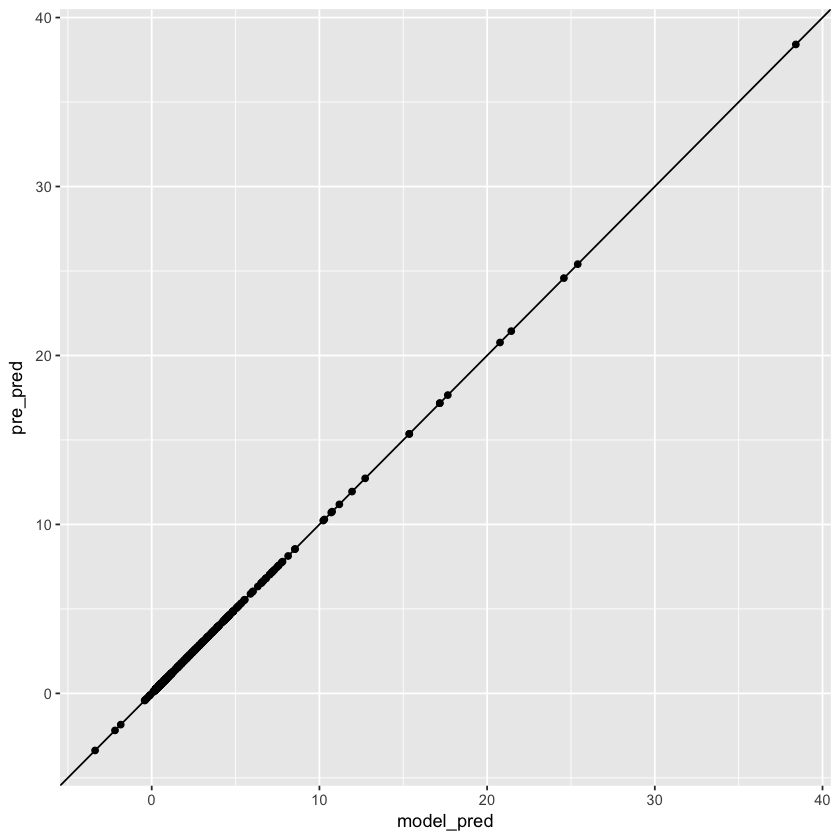

In [275]:
qplot(model_pred, pre_pred) + geom_abline(slope=1)

----

In [223]:
r_model = R_learner_cv(x[i_tr,], w[i_tr], y[i_tr], 
                      model_specs, model_specs, model_specs, k_folds_cv=5) 
tauhat_r_te = predict(r_model, newdata=x[-i_tr,])
tauhat_r_tr = predict(r_model, newdata=x[i_tr,])

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.9300             nan     0.1000    0.9611
     2        7.1384             nan     0.1000    0.7596
     3        6.4149             nan     0.1000    0.7146
     4        5.8253             nan     0.1000    0.5829
     5        5.2903             nan     0.1000    0.5391
     6        4.7741             nan     0.1000    0.4186
     7        4.3830             nan     0.1000    0.3307
     8        3.9933             nan     0.1000    0.3766
     9        3.6165             nan     0.1000    0.3269
    10        3.3269             nan     0.1000    0.2601
    20        1.6419             nan     0.1000    0.0657
    40        0.8516             nan     0.1000    0.0032
    60        0.6792             nan     0.1000   -0.0021
    80        0.6067             nan     0.1000   -0.0018
   100        0.5427             nan     0.1000    0.0009
   120        0.5091             nan     0.1000   -0.0006
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.0284             nan     0.1000    0.9688
     2        7.1370             nan     0.1000    0.8862
     3        6.3913             nan     0.1000    0.7282
     4        5.7286             nan     0.1000    0.6536
     5        5.2147             nan     0.1000    0.4402
     6        4.7191             nan     0.1000    0.4962
     7        4.3036             nan     0.1000    0.4352
     8        3.9372             nan     0.1000    0.3279
     9        3.6235             nan     0.1000    0.2623
    10        3.3141             nan     0.1000    0.2367
    20        1.5815             nan     0.1000    0.0861
    40        0.7490             nan     0.1000    0.0079
    60        0.6013             nan     0.1000    0.0001
    80        0.5380             nan     0.1000   -0.0015
   100        0.4954             nan     0.1000   -0.0009
   120        0.4701             nan     0.1000   -0.0029
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.6169             nan     0.1000    1.0241
     2        7.6727             nan     0.1000    0.8943
     3        6.9539             nan     0.1000    0.7365
     4        6.2973             nan     0.1000    0.6290
     5        5.7039             nan     0.1000    0.5720
     6        5.1926             nan     0.1000    0.3681
     7        4.7303             nan     0.1000    0.4629
     8        4.3188             nan     0.1000    0.4233
     9        3.9883             nan     0.1000    0.2651
    10        3.6797             nan     0.1000    0.1958
    20        1.8075             nan     0.1000    0.0385
    40        0.9373             nan     0.1000    0.0048
    60        0.7847             nan     0.1000   -0.0047
    80        0.7098             nan     0.1000   -0.0123
   100        0.6475             nan     0.1000   -0.0068
   120        0.5843             nan     0.1000   -0.0035
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.9580             nan     0.1000    1.0184
     2        7.1040             nan     0.1000    0.8472
     3        6.3448             nan     0.1000    0.6983
     4        5.7450             nan     0.1000    0.5726
     5        5.2101             nan     0.1000    0.4966
     6        4.7534             nan     0.1000    0.4584
     7        4.3530             nan     0.1000    0.4237
     8        3.9496             nan     0.1000    0.3547
     9        3.6145             nan     0.1000    0.2853
    10        3.2836             nan     0.1000    0.2694
    20        1.5976             nan     0.1000    0.0912
    40        0.7929             nan     0.1000    0.0005
    60        0.6428             nan     0.1000   -0.0070
    80        0.5868             nan     0.1000   -0.0064
   100        0.5434             nan     0.1000   -0.0028
   120        0.5086             nan     0.1000   -0.0049
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.5360             nan     0.1000    0.9202
     2        6.7482             nan     0.1000    0.7329
     3        5.9907             nan     0.1000    0.7490
     4        5.3801             nan     0.1000    0.6023
     5        4.8256             nan     0.1000    0.5201
     6        4.3753             nan     0.1000    0.3842
     7        3.9474             nan     0.1000    0.3732
     8        3.6215             nan     0.1000    0.3194
     9        3.2856             nan     0.1000    0.2934
    10        3.0037             nan     0.1000    0.2457
    20        1.4622             nan     0.1000    0.0693
    40        0.7008             nan     0.1000    0.0075
    60        0.5651             nan     0.1000   -0.0071
    80        0.4985             nan     0.1000    0.0002
   100        0.4608             nan     0.1000   -0.0043
   120        0.4253             nan     0.1000   -0.0040
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3376             nan     0.1000    0.0189
     2        1.3014             nan     0.1000    0.0143
     3        1.2726             nan     0.1000    0.0117
     4        1.2434             nan     0.1000    0.0122
     5        1.2229             nan     0.1000    0.0077
     6        1.2037             nan     0.1000    0.0057
     7        1.1843             nan     0.1000    0.0088
     8        1.1671             nan     0.1000    0.0043
     9        1.1536             nan     0.1000    0.0031
    10        1.1384             nan     0.1000    0.0059
    20        1.0603             nan     0.1000    0.0006
    40        0.9949             nan     0.1000   -0.0007
    60        0.9508             nan     0.1000   -0.0024
    80        0.9121             nan     0.1000   -0.0020
   100        0.8800             nan     0.1000   -0.0016
   120        0.8535             nan     0.1000   -0.0018
   140        

Warning message:
In resamples.default(models): 'gbm' did not have 'returnResamp="final"; the optimal tuning parameters are usedWarning message:
In resamples.default(models): 'glmnet' did not have 'returnResamp="final"; the optimal tuning parameters are used

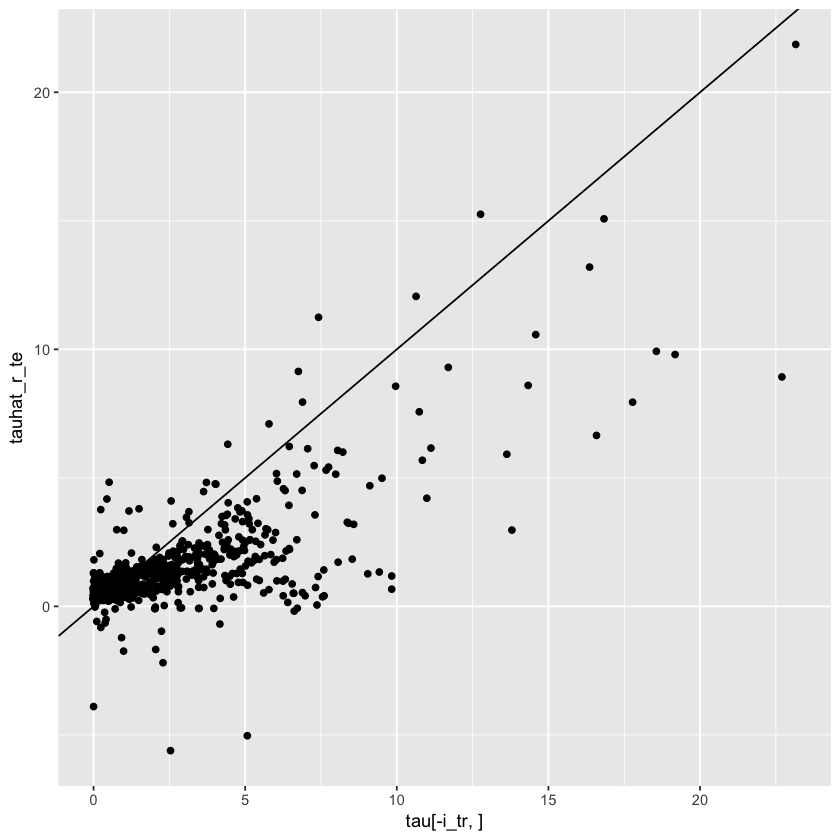

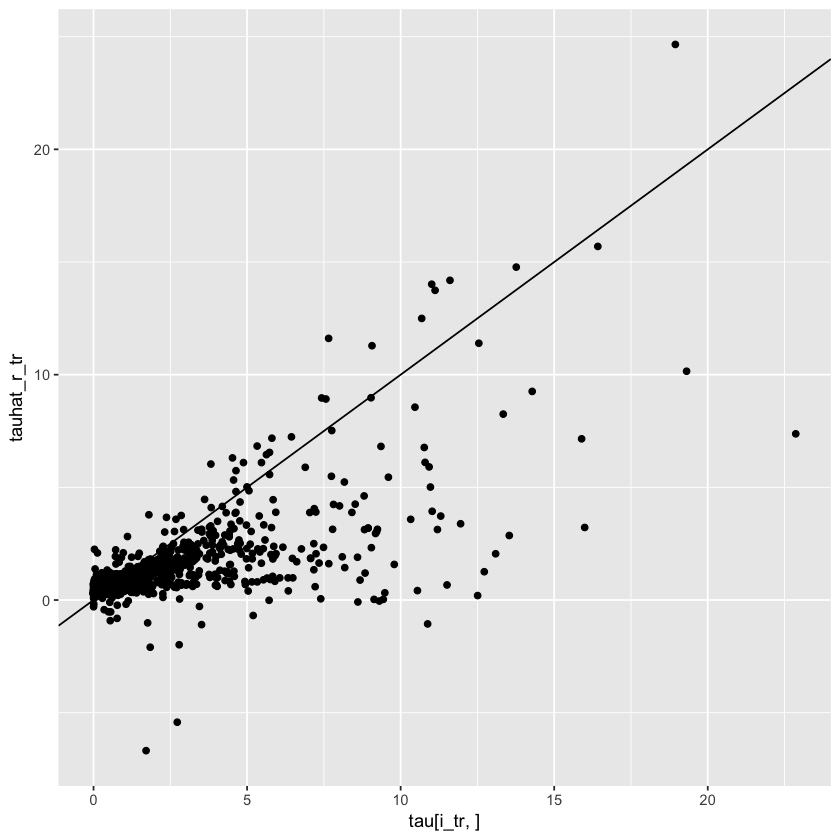

In [224]:
qplot(tau[-i_tr,], tauhat_r_te) + geom_abline(slope=1)
qplot(tau[i_tr,], tauhat_r_tr) + geom_abline(slope=1)

In [225]:
pp = R_learners_pred_test(i_tr, x, w, y, model_specs, model_specs, model_specs)

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.7214             nan     0.1000    0.8079
     2        6.8911             nan     0.1000    0.7583
     3        6.0797             nan     0.1000    0.6635
     4        5.5010             nan     0.1000    0.4730
     5        4.9957             nan     0.1000    0.5134
     6        4.4688             nan     0.1000    0.5188
     7        4.0769             nan     0.1000    0.3765
     8        3.7524             nan     0.1000    0.2592
     9        3.4241             nan     0.1000    0.3316
    10        3.1344             nan     0.1000    0.2522
    20        1.5664             nan     0.1000    0.0546
    40        0.7404             nan     0.1000    0.0018
    60        0.5848             nan     0.1000   -0.0038
    80        0.5014             nan     0.1000   -0.0050
   100        0.4492             nan     0.1000   -0.0076
   120        0.4095             nan     0.1000   -0.0019
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.9678             nan     0.1000    1.0110
     2        7.0877             nan     0.1000    0.8715
     3        6.3799             nan     0.1000    0.7220
     4        5.6924             nan     0.1000    0.5811
     5        5.1447             nan     0.1000    0.5441
     6        4.6798             nan     0.1000    0.3812
     7        4.2209             nan     0.1000    0.4914
     8        3.8766             nan     0.1000    0.2887
     9        3.6055             nan     0.1000    0.2191
    10        3.2803             nan     0.1000    0.2700
    20        1.4911             nan     0.1000    0.1057
    40        0.6737             nan     0.1000    0.0047
    60        0.5398             nan     0.1000   -0.0050
    80        0.4696             nan     0.1000   -0.0063
   100        0.4317             nan     0.1000   -0.0064
   120        0.4047             nan     0.1000   -0.0031
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.2891             nan     0.1000    0.9811
     2        7.3919             nan     0.1000    0.8518
     3        6.7053             nan     0.1000    0.7216
     4        6.0889             nan     0.1000    0.5377
     5        5.5331             nan     0.1000    0.5800
     6        5.0688             nan     0.1000    0.4150
     7        4.5943             nan     0.1000    0.4136
     8        4.2119             nan     0.1000    0.3729
     9        3.8671             nan     0.1000    0.3234
    10        3.5093             nan     0.1000    0.3084
    20        1.7694             nan     0.1000    0.0925
    40        0.9145             nan     0.1000   -0.0127
    60        0.7362             nan     0.1000   -0.0025
    80        0.6405             nan     0.1000   -0.0048
   100        0.5810             nan     0.1000   -0.0091
   120        0.5448             nan     0.1000   -0.0041
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.0197             nan     0.1000    0.9999
     2        7.1202             nan     0.1000    0.7782
     3        6.3609             nan     0.1000    0.6656
     4        5.7364             nan     0.1000    0.5989
     5        5.1912             nan     0.1000    0.5563
     6        4.6697             nan     0.1000    0.4829
     7        4.2428             nan     0.1000    0.4118
     8        3.8305             nan     0.1000    0.3861
     9        3.5248             nan     0.1000    0.2793
    10        3.2131             nan     0.1000    0.3270
    20        1.5144             nan     0.1000    0.0801
    40        0.7211             nan     0.1000    0.0038
    60        0.5749             nan     0.1000    0.0013
    80        0.5107             nan     0.1000   -0.0012
   100        0.4735             nan     0.1000   -0.0025
   120        0.4367             nan     0.1000   -0.0044
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regression

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        8.0773             nan     0.1000    0.9961
     2        7.1790             nan     0.1000    0.8162
     3        6.4839             nan     0.1000    0.6454
     4        5.8003             nan     0.1000    0.6487
     5        5.2227             nan     0.1000    0.5689
     6        4.7076             nan     0.1000    0.3762
     7        4.2373             nan     0.1000    0.3838
     8        3.8764             nan     0.1000    0.2767
     9        3.5586             nan     0.1000    0.3370
    10        3.2484             nan     0.1000    0.2881
    20        1.5433             nan     0.1000    0.0764
    40        0.7493             nan     0.1000   -0.0085
    60        0.6026             nan     0.1000   -0.0051
    80        0.5347             nan     0.1000   -0.0140
   100        0.4811             nan     0.1000   -0.0029
   120        0.4306             nan     0.1000   -0.0026
   140        

Warning message:
In train.default(x = x, y = y, weights = weights, method = method, : cannnot compute class probabilities for regressionWarning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3455             nan     0.1000    0.0166
     2        1.2987             nan     0.1000    0.0166
     3        1.2647             nan     0.1000    0.0156
     4        1.2291             nan     0.1000    0.0118
     5        1.2012             nan     0.1000    0.0086
     6        1.1780             nan     0.1000    0.0097
     7        1.1578             nan     0.1000    0.0084
     8        1.1402             nan     0.1000    0.0083
     9        1.1222             nan     0.1000    0.0048
    10        1.1076             nan     0.1000    0.0043
    20        1.0244             nan     0.1000   -0.0006
    40        0.9407             nan     0.1000   -0.0001
    60        0.8854             nan     0.1000   -0.0005
    80        0.8441             nan     0.1000   -0.0014
   100        0.8101             nan     0.1000   -0.0013
   120        0.7838             nan     0.1000   -0.0017
   140        

Warning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        3.5005             nan     0.1000    0.0893



Warning message:
In nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, : There were missing values in resampled performance measures.

In [234]:
r_model$bestTune

n.trees interaction.depth shrinkage n.minobsinnode
14     261                 3       0.1              3

In [237]:
tauhat_r_te_2 = pp %>% filter(model=="gbm@261~3~0.1~3") %>% arrange(index) %>% pull(est_effect)

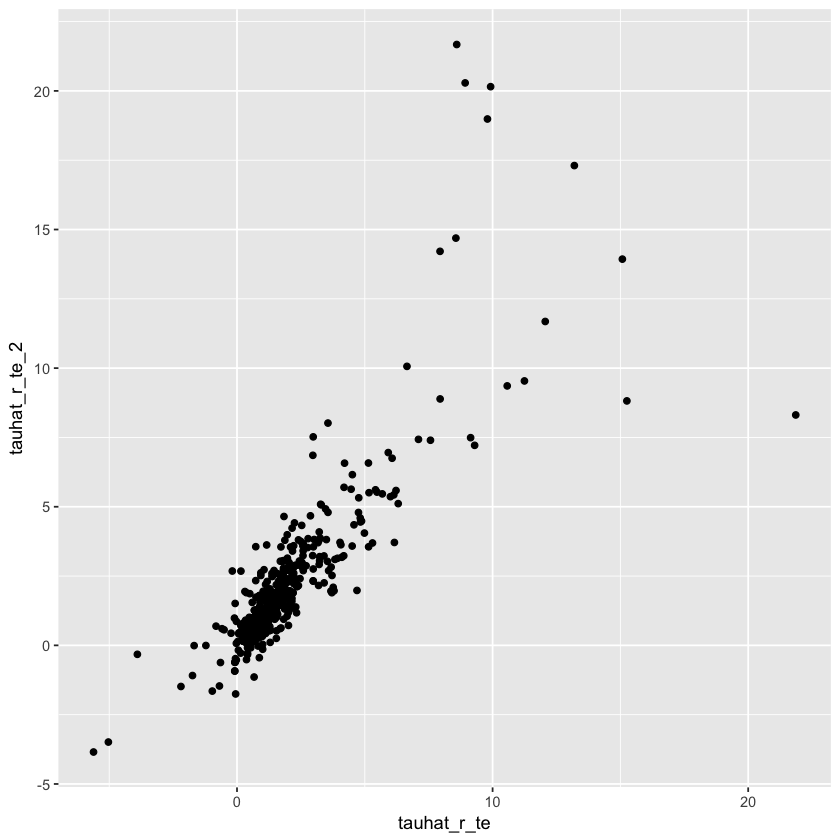

In [238]:
qplot(tauhat_r_te, tauhat_r_te_2)

In [226]:
tmses = pp %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((est_effect - tau[-i_tr])^2))

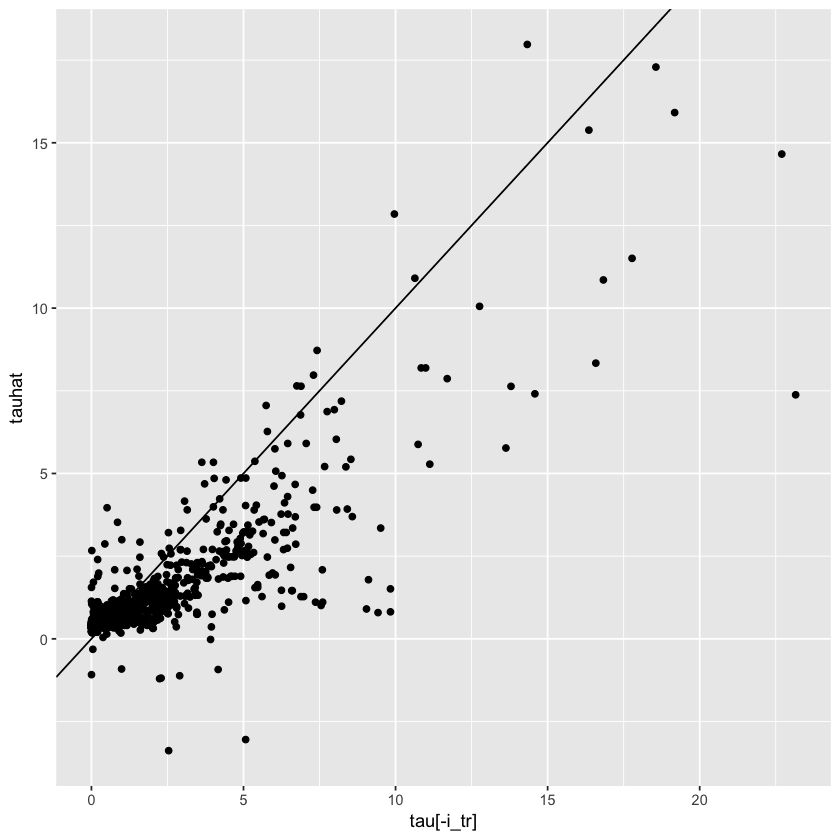

In [227]:
best_model = tmses %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = pp %>% filter(model==best_model) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [228]:
best_model

[1] "gbm@141~3~0.1~3"

In [229]:
tmses_hat = pp %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((a-b*est_effect)^2))

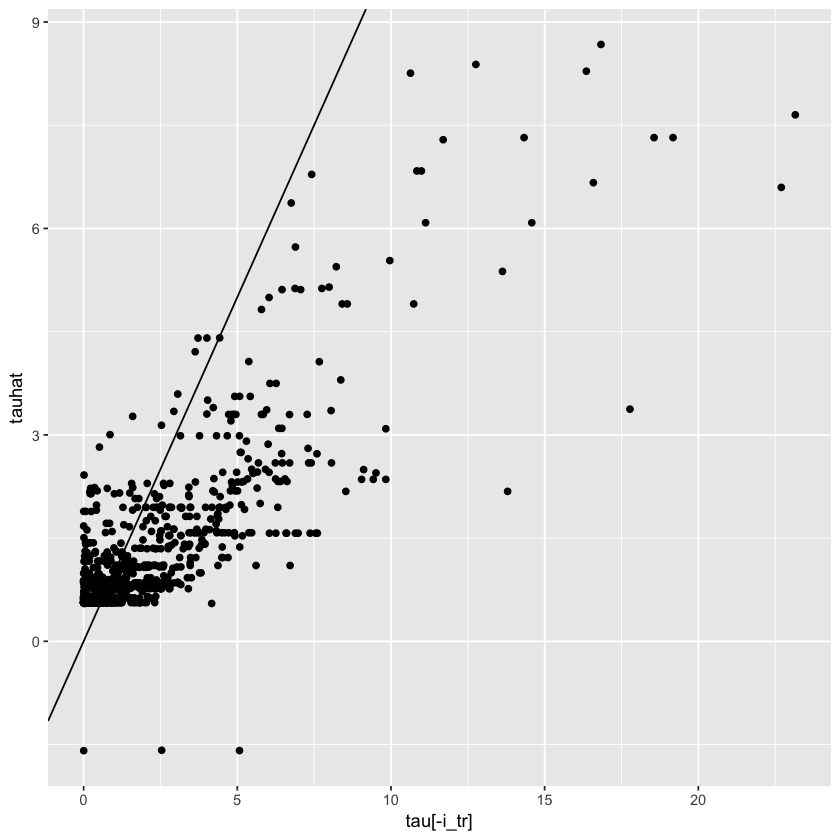

In [230]:
best_model_hat = tmses_hat %>% filter(tmse == min(tmse)) %>% pull(model) %>% first()
tauhat = pp %>% filter(model==best_model_hat) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [231]:
best_model_hat

[1] "gbm@41~3~0.1~3"

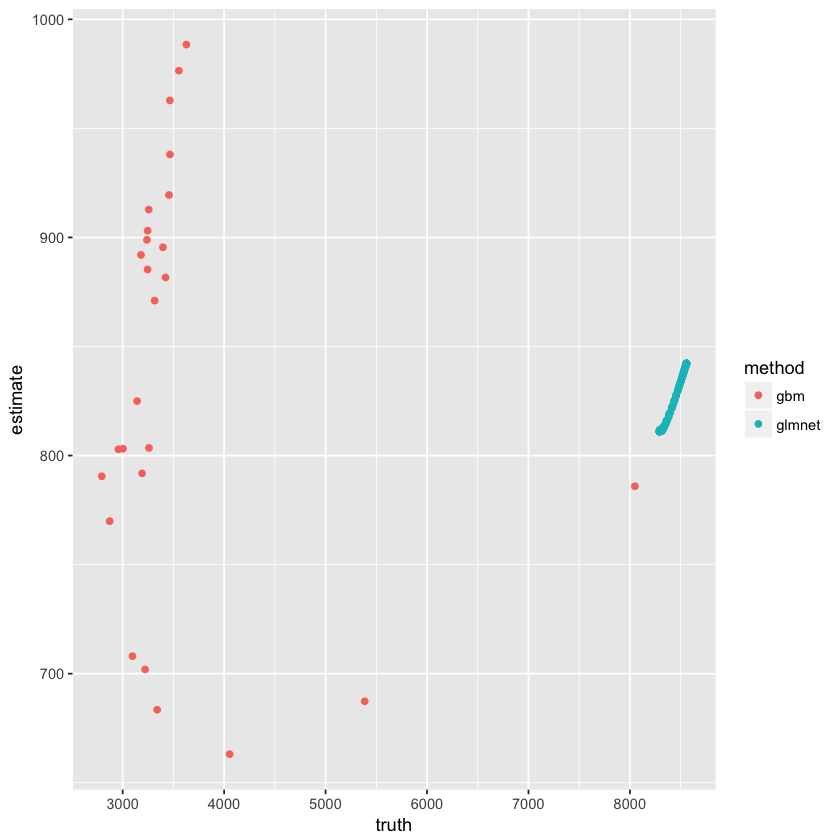

In [232]:
inner_join(tmses, tmses_hat, by="model") %>% 
    rename(truth=tmse.x, estimate=tmse.y) %>%
    separate(model, c("method", "params"), sep="@") %$%
qplot(truth, estimate, color=method) 

----

In [215]:
tau_hat_S = S_learners_pred_test(i_tr, x, w, y, model_specs)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1      425.6206             nan     0.1000  -10.8933
     2      401.9709             nan     0.1000   12.2374
     3      375.8875             nan     0.1000   29.6627
     4      354.6157             nan     0.1000   10.7895
     5      334.3665             nan     0.1000   12.0918
     6      319.0629             nan     0.1000   13.0341
     7      296.3732             nan     0.1000   17.4327
     8      279.8605             nan     0.1000    4.4596
     9      266.3412             nan     0.1000    7.0146
    10      249.3914             nan     0.1000   11.5298
    20      171.1412             nan     0.1000    3.0168
    40      108.9919             nan     0.1000   -1.0032
    60       77.5639             nan     0.1000   -1.9323
    80       62.5960             nan     0.1000   -0.6543
   100       53.2487             nan     0.1000   -0.8790
   120       45.5989             nan     0.1000    0.2523
   140       4

In [216]:
tmses = tau_hat_S %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((est_effect - tau[-i_tr])^2))

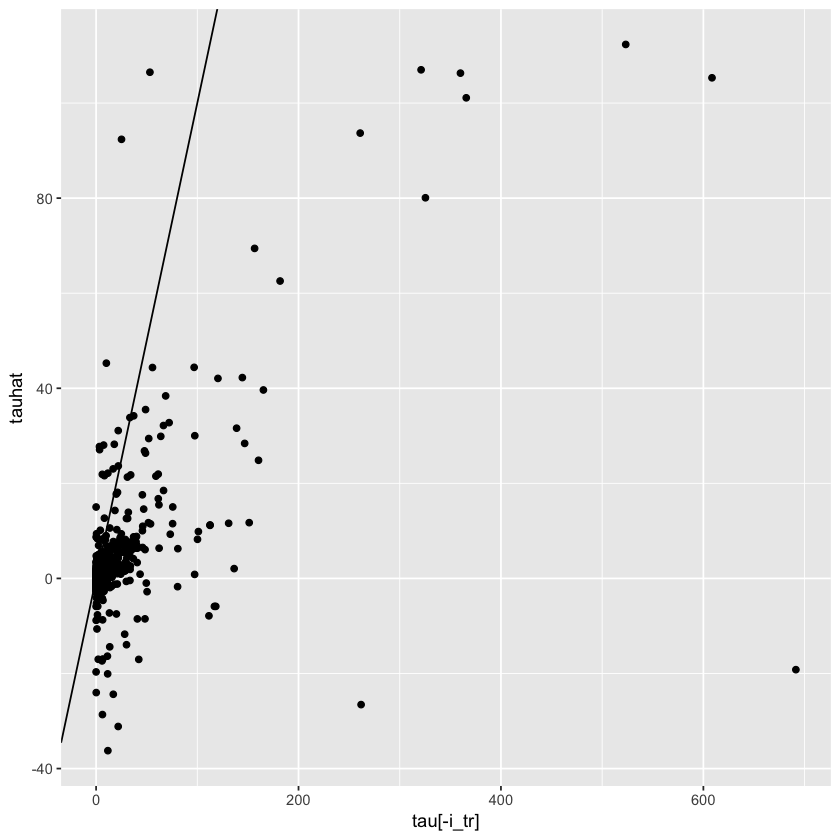

In [217]:
best_model = tmses %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = tau_hat_S %>% filter(model==best_model) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [218]:
tmses_hat = tau_hat_S %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((a-b*est_effect)^2))

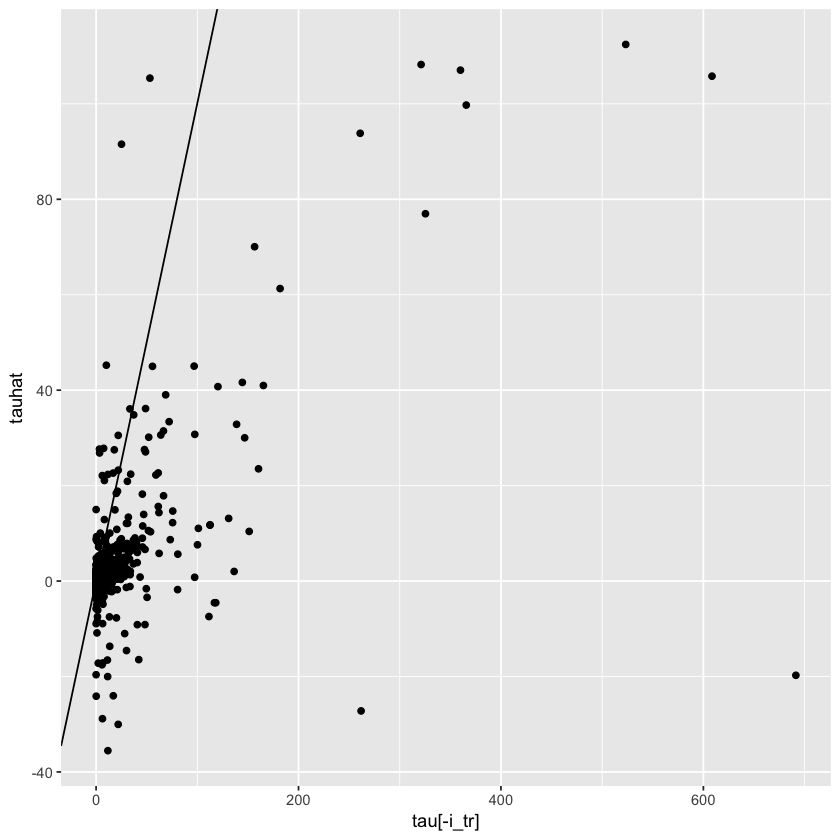

In [219]:
best_model_hat = tmses_hat %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = tau_hat_S %>% filter(model==best_model_hat) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [220]:
best_model_hat

[1] "gbm@501~3~0.1~3"

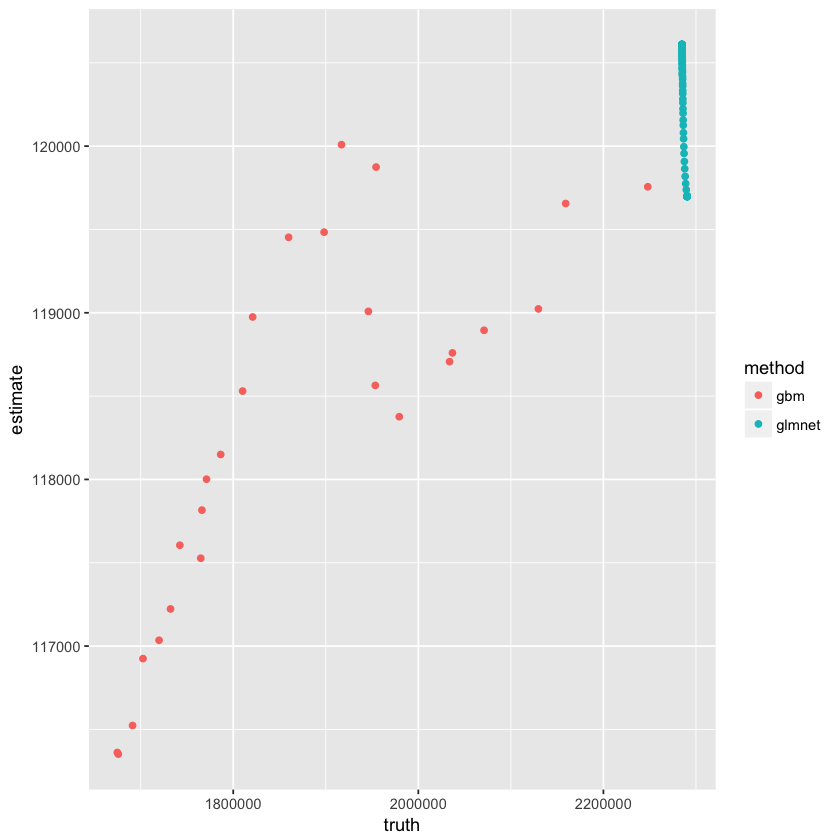

In [221]:
inner_join(tmses, tmses_hat, by="model") %>% 
    rename(truth=tmse.x, estimate=tmse.y) %>%
    separate(model, c("method", "params"), sep="@") %$%
qplot(truth, estimate, color=method) 